### LSTM

In [1]:
#import
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### setup device

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Making data ready

In [5]:
data = pd.read_csv("./data_saved/EURUSD_M1_202401.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()

# data_norm.head(10)

             timestamp     open     high      low    close
0  2024-01-02 00:01:00  1.10235  1.10239  1.10224  1.10224
1  2024-01-02 00:02:00  1.10223  1.10227  1.10220  1.10220
2  2024-01-02 00:03:00  1.10219  1.10226  1.10215  1.10215
3  2024-01-02 00:04:00  1.10225  1.10225  1.10223  1.10223
4  2024-01-02 00:05:00  1.10226  1.10229  1.10220  1.10220
5  2024-01-02 00:06:00  1.10220  1.10220  1.10217  1.10217
6  2024-01-02 00:07:00  1.10220  1.10220  1.10210  1.10210
7  2024-01-02 00:08:00  1.10214  1.10221  1.10214  1.10214
8  2024-01-02 00:09:00  1.10221  1.10225  1.10220  1.10220
9  2024-01-02 00:10:00  1.10226  1.10231  1.10220  1.10220
               open          high           low         close
count  26973.000000  26973.000000  26973.000000  26973.000000
mean       1.091785      1.091853      1.091716      1.091716
std        0.004453      0.004453      0.004454      0.004454
min        1.081290      1.081390      1.081280      1.081280
25%        1.088150      1.088200      1.

Ploting the data....


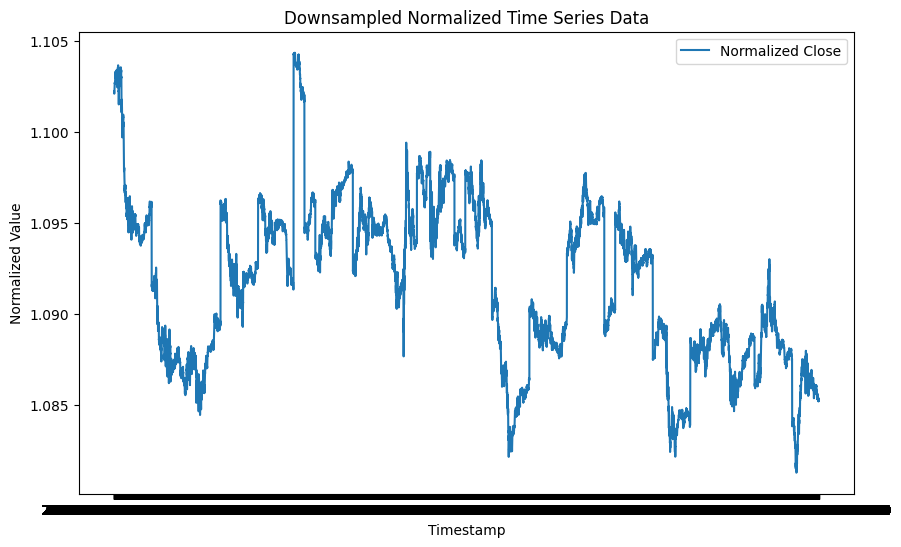

In [6]:

print("Ploting the data....")

# Downsample the data
# downsampled_data_norm = data_norm.resample('1D', on='timestamp').mean()

# Plot the downsampled data
plt.figure(figsize=(10, 6))
# plt.plot(data_norm['timestamp'], data_norm['open'], label='Normalized Open')
# plt.plot(data_norm['timestamp'], data_norm['high'], label='Normalized High')
# plt.plot(data_norm['timestamp'], data_norm['low'], label='Normalized Low')
plt.plot(data['timestamp'], data['close'], label='Normalized Close')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Downsampled Normalized Time Series Data')
plt.legend()
plt.show()

### move data to tensor gpu

In [9]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor

tensor([[[1.1022],
         [1.1022],
         [1.1021],
         ...,
         [1.0854],
         [1.0853],
         [1.0852]]], device='cuda:0')

In [13]:

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

# Parameters
input_size = 4  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.0094
Epoch [2/1000], Loss: 1.0073
Epoch [3/1000], Loss: 1.0055
Epoch [4/1000], Loss: 1.0040
Epoch [5/1000], Loss: 1.0027
Epoch [6/1000], Loss: 1.0017
Epoch [7/1000], Loss: 1.0009
Epoch [8/1000], Loss: 1.0004
Epoch [9/1000], Loss: 1.0001
Epoch [10/1000], Loss: 1.0001
Epoch [11/1000], Loss: 1.0003
Epoch [12/1000], Loss: 1.0005
Epoch [13/1000], Loss: 1.0008
Epoch [14/1000], Loss: 1.0009
Epoch [15/1000], Loss: 1.0008
Epoch [16/1000], Loss: 1.0007
Epoch [17/1000], Loss: 1.0005
Epoch [18/1000], Loss: 1.0003
Epoch [19/1000], Loss: 1.0002
Epoch [20/1000], Loss: 1.0001
Epoch [21/1000], Loss: 1.0000
Epoch [22/1000], Loss: 1.0000
Epoch [23/1000], Loss: 1.0000
Epoch [24/1000], Loss: 1.0001
Epoch [25/1000], Loss: 1.0001
Epoch [26/1000], Loss: 1.0001
Epoch [27/1000], Loss: 1.0001
Epoch [28/1000], Loss: 1.0001
Epoch [29/1000], Loss: 1.0001
Epoch [30/1000], Loss: 1.0001
Epoch [31/1000], Loss: 1.0001
Epoch [32/1000], Loss: 1.0001
Epoch [33/1000], Loss: 1.0001
Epoch [34/1000], Lo

KeyboardInterrupt: 

### LSTM in every 100 bars

In [17]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out





### Train Modals

In [19]:
# Parameters
input_size = 1  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
forecast_interval = 50
losses = []
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    # Probabilistic forecasting every forecast_interval timestamps
    if (epoch+1) % forecast_interval == 0:
        with torch.no_grad():
            # Generate probabilistic forecasts for the next timestamp
            # You can adjust this part to implement your desired forecasting method
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # Visualize the loss over epochs
            plt.plot(losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss over Epochs')
            plt.show()

            forecast_input = data_tensor[:, -1:, :]  # Use the last timestamp as input
            forecast_output = model(forecast_input)
            print(forecast_input)
            print(forecast_output)
            
            # Append the forecasted values to the data tensor
            data_tensor = torch.cat([data_tensor, forecast_output.unsqueeze(1)], dim=1)

 10%|█         | 100/1000 [00:14<02:24,  6.22it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26984, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 101/1000 [00:14<02:26,  6.12it/s]

Epoch [100/1000], Loss: 0.0004
tensor([[[0.2143]]], device='cuda:0')
tensor([[0.2318]], device='cuda:0')


 20%|██        | 200/1000 [00:29<01:56,  6.88it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26985, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|██        | 201/1000 [00:29<01:57,  6.80it/s]

Epoch [200/1000], Loss: 0.0003
tensor([[[0.2318]]], device='cuda:0')
tensor([[0.2318]], device='cuda:0')


 30%|███       | 300/1000 [00:44<01:42,  6.85it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26986, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 30%|███       | 301/1000 [00:44<01:45,  6.64it/s]

Epoch [300/1000], Loss: 0.0004
tensor([[[0.2318]]], device='cuda:0')
tensor([[0.2319]], device='cuda:0')


 40%|████      | 400/1000 [00:59<01:34,  6.33it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26987, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 40%|████      | 401/1000 [00:59<01:35,  6.28it/s]

Epoch [400/1000], Loss: 0.0004
tensor([[[0.2319]]], device='cuda:0')
tensor([[0.2320]], device='cuda:0')


 50%|█████     | 500/1000 [01:14<01:12,  6.92it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26988, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 501/1000 [01:14<01:12,  6.87it/s]

Epoch [500/1000], Loss: 0.0004
tensor([[[0.2320]]], device='cuda:0')
tensor([[0.2321]], device='cuda:0')


 60%|██████    | 600/1000 [01:29<01:00,  6.64it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26989, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 60%|██████    | 601/1000 [01:29<00:59,  6.68it/s]

Epoch [600/1000], Loss: 0.0004
tensor([[[0.2321]]], device='cuda:0')
tensor([[0.2321]], device='cuda:0')


 70%|███████   | 700/1000 [01:44<00:46,  6.47it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26990, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 70%|███████   | 701/1000 [01:44<00:45,  6.62it/s]

Epoch [700/1000], Loss: 0.0005
tensor([[[0.2321]]], device='cuda:0')
tensor([[0.2322]], device='cuda:0')


 80%|████████  | 800/1000 [02:00<00:28,  6.91it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26991, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|████████  | 801/1000 [02:00<00:28,  6.92it/s]

Epoch [800/1000], Loss: 0.0005
tensor([[[0.2322]]], device='cuda:0')
tensor([[0.2322]], device='cuda:0')


 90%|█████████ | 900/1000 [02:14<00:14,  6.83it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 26992, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 90%|█████████ | 901/1000 [02:15<00:14,  6.87it/s]

Epoch [900/1000], Loss: 0.0005
tensor([[[0.2322]]], device='cuda:0')
tensor([[0.2322]], device='cuda:0')


 90%|█████████ | 903/1000 [02:15<00:14,  6.78it/s]

### Save Modal for more evaulation

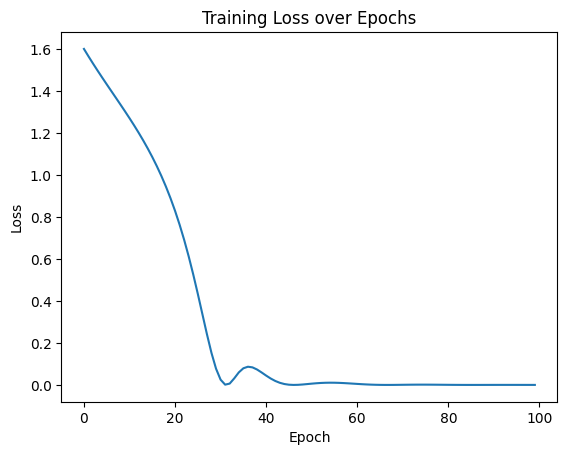

In [18]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [14]:
# Save the trained model to local device
torch.save(model.state_dict(), './TrainedModals/lstm_model_probabilistic.pth')